<a href="https://colab.research.google.com/github/dan-manolescu/data-structures-fun/blob/main/C11_B_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
from typing import Any, ForwardRef, Tuple

In [40]:
class BTreeNode:
    def __init__(self, k: int):
        self.k = k
        self.size = 0
        self.is_leaf = True
        # Both keys and children use one extra storage so accomodate an insert
        # that might overspill the node prior to splitting (see insert function).
        self.keys = [None] * (2 * k + 1)
        self.children = [None] * (2 * k + 2)

    def BTreeNodeSearch(self, target: Any) -> Any:
        # Search the node's key list for the target.
        # For simplicity sake we use a linear search, but a binary search is
        # a good option as well.
        i = 0
        while i < self.size and target >= self.keys[i]:
            # Check if we found a matching key in the current node.
            if target == self.keys[i]:
                return self.keys[i]
            i += 1

        # If we didn't find a match then descend to the correct child.
        if self.is_leaf:
            # Current node is a leaf then there's no match in the tree.
            return None
        return self.children[i].BTreeNodeSearch(target)

    def BtreeNodeAddKey(self, key: Any, next_child: ForwardRef('BTreeNode')) -> None:
        '''
        Helper function to insert a key into a non-full node.
        <next_child> is a pointer to the child node (the child after the new key).
        For a leaf node the next_child pointer is ignored.
        '''
        # Start at the end of the keys array and move towards 0.
        # At each step check if the new key should be inserted here
        # and if not shift the elements of keys and children back one position.
        i = self.size - 1
        while i >= 0 and key < self.keys[i]:
            self.keys[i + 1] = self.keys[i]
            if not self.is_leaf:
                self.children[i + 2] = self.children[i + 1]
            i -= 1

        # Insert both the key and the pointer to the child node.
        # By this time we have already shifted the following elements.
        self.keys[i + 1] = key
        if not self.is_leaf:
            self.children[i + 2] = next_child
        # Adjust the size of the node with the new insertion.
        self.size += 1

    def BTreeNodeIsOverFull(self) -> bool:
        '''
        Helper function to indicate if the node contains more than 2k items
        '''
        return self.size == (2 * self.k + 1)

    def BTreeNodeSplit(self, child_index: int) -> None:
        '''
        Helper function that takes the index of a child of the node and splits
        that child. Everything before that index is retained in the original
        child. Everythign after that index is cleared from the child and added
        to a newly created child node. The key at the index itself is cleared
        from the child and added to the current (parent) node.
        '''
        # old_child is the node to split, new_child is the new empty sibling node.
        # The new node is at the same level as old_child so copy is_leaf.
        old_child = self.children[child_index]
        new_child = BTreeNode(self.k)
        new_child.is_leaf = old_child.is_leaf

        # Get the index and key used for the split point for old_child.
        split_index = int(old_child.size / 2)
        split_key = old_child.keys[split_index]

        # Copy the larger half of the keys (and their children) to new_child and erase them from old_child.
        new_index = 0
        old_index = split_index + 1
        while old_index < old_child.size:
            new_child.keys[new_index] = old_child.keys[old_index]
            old_child.keys[old_index] = None

            if not old_child.is_leaf:
                new_child.children[new_index] = old_child.children[old_index]
                old_child.children[old_index] = None
            new_index += 1
            old_index += 1

        # Copy the remainining child (after the last key).
        # This needs to be done since the children array is one element longer.
        if not old_child.is_leaf:
            new_child.children[new_index] = old_child.children[old_child.size]
            old_child.children[old_child.size] = None

        # Remove the key at index and add it to the current node.
        old_child.keys[split_index] = None
        self.BtreeNodeAddKey(split_key, new_child)

        # Update the sizes of the nodes.
        new_child.size = old_child.size - split_index - 1
        old_child.size = split_index

    def BTreeNodeInsert(self, key: Any) -> None:
        '''
        Insertion function. The addition is done at leaf level then recursively
        return up the tree checking if the recently accessed child node is full
        and it needs to be split.
        '''
        # First figure out the correct location for key in the keys array.
        i = 0
        while i < self.size and key >= self.keys[i]:
            if key == self.keys[i]:
                # Here we can update the data for this key
                return
            i += 1

        if self.is_leaf:
            # If the node is a leaf then just add the key (and shift the elements)
            self.BtreeNodeAddKey(key, None)
        else:
            # Recursively insert into the child nodes
            self.children[i].BTreeNodeInsert(key)
            # Check if we insert too many elements and split the overfull child at the parent.
            if self.children[i].BTreeNodeIsOverFull():
                self.BTreeNodeSplit(i)

In [41]:
class BTree:
    def __init__(self, k: int):
        self.k = k
        self.root = BTreeNode(k)

    def BTreeSearch(self, target: Any) -> Any:
        return self.root.BTreeNodeSearch(target)

    def BTreeInsert(self, key: Any) -> None:
        '''
        Insert a new key in the BTree and handle the special case for the root
        node (splitting the rood node = increase the height of the tree).
        '''
        # Start by inserting the key into the root node. This will recursively
        # descend the tree, insert the key in the right location then return
        # and fix all nodes except the root.
        self.root.BTreeNodeInsert(key)

        # Check if the root node has too many elements.
        if self.root.BTreeNodeIsOverFull():
            # We add a new level by creating a new root node.
            new_root = BTreeNode(self.k)
            new_root.is_leaf = False
            new_root.size = 0

            # Old root is a child of the new root which is then split.
            # After the split the new root will have exactly one key and two children.
            new_root.children[0] = self.root
            new_root.BTreeNodeSplit(0)
            self.root = new_root

Some utility function to be able to draw a btree representation using graphviz.
The function will draw each node as a set of records with children pointers (represented as a * character) interlaced with key values.

In [71]:
import graphviz
from graphviz import nohtml

def visualize_btree(btree: BTree) -> graphviz.Digraph:
    dot = graphviz.Digraph(node_attr={'shape':'record', 'height':'.1'})

    def generate_node(node: BTreeNode) -> Tuple[str, str]:
        name = []
        content = []
        for i, key in enumerate(node.keys):
            # Put a * cell for a children node pointer.
            if node.children[i] != None:
                content.append(f'<f{i}> *|')
            # Put a cell with the key value.
            if key != None:
                name.append(str(key))
                content.append(f' {str(key)}|')
            # Make sure to remove the last empty cell (don't put a | at the end).
            if i == len(node.keys) - 1 and node.children[-1] == None:
                content[-1] = content[-1][:-1]
        if node.children[-1] != None:
            content.append(f'<f{len(node.children) - 1}> *')
        return (''.join(name), ''.join(content))

    def visualize_btreenode(node: BTreeNode, dot: graphviz.Digraph) -> str:
        name, content = generate_node(node)
        dot.node(name, nohtml(content))

        for i, child in enumerate(node.children):
            if child != None:
                child_name = visualize_btreenode(child, dot)
                dot.edge(f'{name}:f{i}', f'{child_name}')
        return name

    visualize_btreenode(btree.root, dot)

    return dot

Some example of building a BTree. At the end we display it.

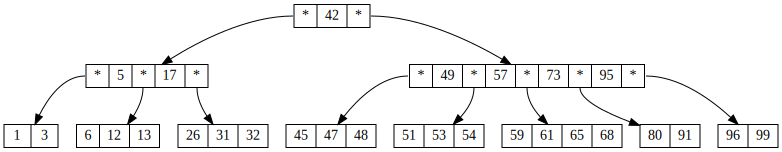

In [72]:
btree = BTree(2)
btree.BTreeInsert(1)
btree.BTreeInsert(3)
btree.BTreeInsert(5)
btree.BTreeInsert(6)
btree.BTreeInsert(13)
btree.BTreeInsert(17)
btree.BTreeInsert(26)
btree.BTreeInsert(32)
btree.BTreeInsert(42)
btree.BTreeInsert(47)
btree.BTreeInsert(48)
btree.BTreeInsert(49)
btree.BTreeInsert(53)
btree.BTreeInsert(54)
btree.BTreeInsert(57)
btree.BTreeInsert(59)
btree.BTreeInsert(65)
btree.BTreeInsert(73)
btree.BTreeInsert(80)
btree.BTreeInsert(91)
btree.BTreeInsert(95)
btree.BTreeInsert(96)
btree.BTreeInsert(99)
btree.BTreeInsert(12)
btree.BTreeInsert(31)
btree.BTreeInsert(45)
btree.BTreeInsert(61)
btree.BTreeInsert(68)
btree.BTreeInsert(51)

visualize_btree(btree)